🎯 Goal
We want to build a model that takes in the current and past positions of a taxi (possibly over time) and predicts which GMM cluster it will move to next.

✅ Step-by-Step Breakdown
1. Prepare Your Data
You’ll need data that represents:

The input: e.g., past cluster IDs or positions (time-series data).

The output: the next GMM cluster the taxi moves to.

For example:

python
Copy
Edit
taxi_id | timestamp         | gmm_cluster
--------|-------------------|-------------
ABC123  | 2025-06-01 10:00  | 3
ABC123  | 2025-06-01 10:05  | 3
ABC123  | 2025-06-01 10:10  | 4  <- this is what we want to predict
➡️ You create sequences of past clusters or positions to feed into the model, and train it to predict the next cluster.


🔍 In Your Case: What Are You Predicting?
You are trying to predict the next GMM cluster a taxi will move to. That means:
✅ Output Label (y) = the next GMM cluster number
GMM clusters are typically labeled as integers:
0, 1, 2, ..., up to however many clusters you chose (in your case, k = 11 → clusters from 0 to 10).

2. Feature Engineering
Build the features:

Time-based features (hour, day, etc.)

Cluster sequences (e.g., last 3 GMM clusters)

Optionally include lat/lon if more precision is needed.

You can use a sliding window approach:
Input (X): [3, 3, 4] ➡ Output (y): 5

🧾 Example
Imagine you have the following data for one taxi:

Time	GMM Cluster
10:00 AM	3
10:05 AM	3
10:10 AM	4
10:15 AM	6
10:20 AM	6

You can build your training data like this:

Input (X): [3, 3] → Output (y): 4

Input (X): [3, 4] → Output (y): 6

Input (X): [4, 6] → Output (y): 6

Here, y = the GMM cluster the taxi enters after the given sequence.

🔢 Final Format
For classification:

y values = integers (like 0, 1, ..., 10)

These are labels your classifier will learn to predict.

3. Split the Dataset
Use train_test_split() to divide into:

Training data: used to fit the model.

Test data: used to evaluate performance.<br>
from sklearn.model_selection import train_test_split <br>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


4. Choose a Model
Since your target is a cluster label (classification), you can try:

Random Forest: Easy to use and performs well.

GRU/LSTM: For deep learning with sequences.

XGBoost: Another strong model.

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)


5. Make Predictions
Use your trained model to predict:

python
Copy
Edit
y_pred = model.predict(X_test)

6. Evaluate the Model
Use accuracy or F1-score:

python
Copy
Edit
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

7. Analyze the Results
Are certain clusters predicted better than others?

Is the model confused by nearby clusters?

You can use a confusion matrix to visualize this.

🧠 Optional: Use a GRU for Better Performance
If you're using time sequences:

You can build a GRU model using TensorFlow or PyTorch.

It will take sequences like [3, 3, 4] and predict the next cluster.

✅ Summary
Part	What it is
X (input)	Previous cluster IDs (or positions, times, etc.)
y (output)	The next GMM cluster ID (integer label)

In [13]:
import pandas as pd

# Load the saved GMM output
df_clean = pd.read_csv('D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/gmm_cluster_output_20250621_2318.csv')

# Check the first few rows
df_clean.head(5)

,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier,gmm_cluster,gmm_cluster_confidence
0,2,2008-02-02 13:33:52,116.36422,39.88781,1201959232,14,0,3,0.803400
1,2,2008-02-02 13:37:16,116.37481,39.88782,1201959436,14,0,3,0.686885
2,2,2008-02-02 13:38:53,116.37677,39.88791,1201959533,14,0,3,0.657319
3,2,2008-02-02 13:42:18,116.38033,39.88795,1201959738,14,0,3,0.598102
4,2,2008-02-02 13:43:55,116.39392,39.89014,1201959835,14,0,6,0.411855


In [14]:
# Ensure timestamp is datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean.head(5)

,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier,gmm_cluster,gmm_cluster_confidence
0,2,2008-02-02 13:33:52,116.36422,39.88781,1201959232,14,0,3,0.803400
1,2,2008-02-02 13:37:16,116.37481,39.88782,1201959436,14,0,3,0.686885
2,2,2008-02-02 13:38:53,116.37677,39.88791,1201959533,14,0,3,0.657319
3,2,2008-02-02 13:42:18,116.38033,39.88795,1201959738,14,0,3,0.598102
4,2,2008-02-02 13:43:55,116.39392,39.89014,1201959835,14,0,6,0.411855


In [15]:
# Sort by taxi and time
df_sorted = df_clean.sort_values(by=['taxiid', 'timestamp'])
df_sorted.head(3)

,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier,gmm_cluster,gmm_cluster_confidence
0,2,2008-02-02 13:33:52,116.36422,39.88781,1201959232,14,0,3,0.803400
1,2,2008-02-02 13:37:16,116.37481,39.88782,1201959436,14,0,3,0.686885
2,2,2008-02-02 13:38:53,116.37677,39.88791,1201959533,14,0,3,0.657319


In [16]:
# Define sequence length (how many previous clusters to look at)
SEQ_LENGTH = 2

X = []
y = []
taxi_ids = []

Step-by-step Breakdown:
df_sorted.groupby('taxiid'):

Groups your entire dataset by taxiid.

Each group is a smaller DataFrame — only the records for that one taxi.

The data is assumed to be time-sorted, so it's like:
"What did this taxi do, in order?"

group['gmm_cluster']:

From the taxi's group, this pulls just the column gmm_cluster, which has cluster labels for each GPS point.

Example: Series([3, 1, 2, 5])

.tolist():

Converts that column into a Python list.

Example: [3, 1, 2, 5]

In [17]:
# Process each taxi separately
# “For each taxi, give me the ordered list of GMM clusters that the taxi visited, one by one.”
for taxi_id, group in df_sorted.groupby('taxiid'):
    clusters = group['gmm_cluster'].tolist()

    # Create sequences of previous clusters to predict the next one
    for i in range(len(clusters) - SEQ_LENGTH):
        X.append(clusters[i:i + SEQ_LENGTH])   # input sequence
        y.append(clusters[i + SEQ_LENGTH])     # next cluster
        taxi_ids.append(taxi_id)  # 🧠 add this line

In [25]:
# Convert to DataFrame or NumPy array
import numpy as np
X = np.array(X)
y = np.array(y)

# Optionally check shapes
print("Input shape:", X.shape)
print("Output shape:", y.shape)
print("Sample X:", X[:5])
print("Sample y:", y[:5])


Input shape: (349170, 2)
Output shape: (349170,)
Sample X: [[3 3]
 [3 3]
 [3 3]
 [3 6]
 [6 6]]
Sample y: [3 3 6 6 6]


In [18]:
X_df = pd.DataFrame(X, columns=[f'prev_{i}' for i in range(SEQ_LENGTH)])
X_df['taxiid'] = taxi_ids  # attach taxi IDs
y_df = pd.Series(y)

✅ Step-by-Step Model Progression
✅ 1. Baseline Model: Most Frequent Cluster
Idea: Predict the most common cluster a taxi visits.

Why: A simple benchmark to compare against.

Pros: Easy to implement and fast.

Cons: Doesn’t use sequence info.

✅ 2. Classical ML Model: Random Forest or Logistic Regression
Idea: Use the last n clusters as features to predict the next one.

Why: Adds pattern detection from past clusters.

Pros: Good performance on structured data, fast.

Cons: Still ignores sequence order internally.

✅ 3. Deep Learning: GRU (Gated Recurrent Unit)
Idea: Feed sequences of clusters to a recurrent neural network to learn temporal behavior.

Why: Designed to model sequences over time.

Pros: Captures sequential dependencies.

Cons: Needs more data and compute, harder to interpret.

🧠 What the Baseline Model Does:
It looks at each taxi's history and always predicts the most frequently visited cluster as the next one.
This is useful because if a model can’t beat this, it’s probably not learning meaningful behavior.

✅ Input:
You already have:

A list of cluster sequences per taxiid (from df_sorted.groupby('taxiid'))

X_df and y_df (sequence and label pairs)

In [19]:
from collections import Counter
from sklearn.metrics import accuracy_score

# Step 1: Create a dictionary of each taxi's most frequent cluster
taxi_most_common_cluster = {}

for taxi_id, group in df_sorted.groupby('taxiid'):
    clusters = group['gmm_cluster'].tolist()
    most_common = Counter(clusters).most_common(1)[0][0]
    taxi_most_common_cluster[taxi_id] = most_common

# Step 2: Predict the most frequent cluster for each sequence
y_pred = []

for i in range(len(X)):
    taxi_id = X_df.iloc[i]['taxiid']  # assuming you include 'taxiid' in X_df
    pred_cluster = taxi_most_common_cluster.get(taxi_id, 0)  # fallback to 0
    y_pred.append(pred_cluster)

# Step 3: Evaluate baseline performance
accuracy = accuracy_score(y_df, y_pred)
print(f"Baseline Accuracy (Most Frequent Cluster): {accuracy:.4f}")

Baseline Accuracy (Most Frequent Cluster): 0.5427


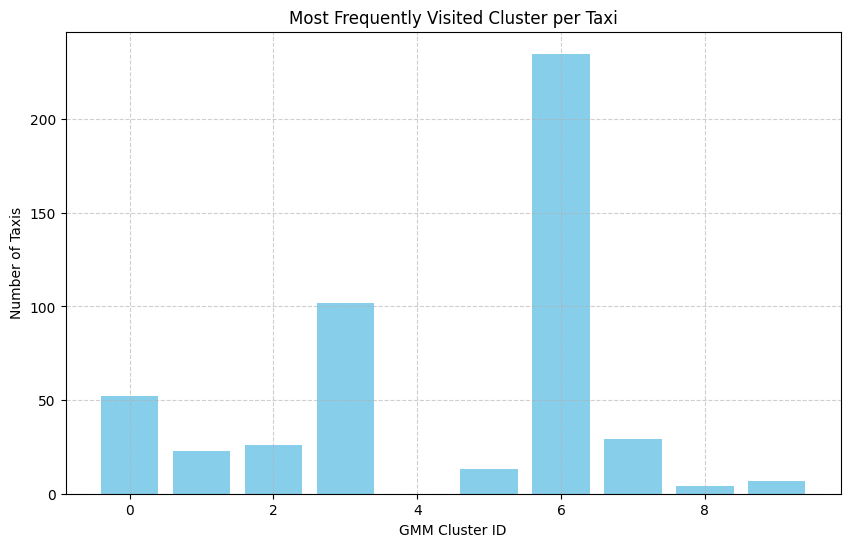

In [20]:
import matplotlib.pyplot as plt

# Count how many taxis had each cluster as their most common
cluster_counts = Counter(taxi_most_common_cluster.values())

# Plot
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue')
plt.xlabel("GMM Cluster ID")
plt.ylabel("Number of Taxis")
plt.title("Most Frequently Visited Cluster per Taxi")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

🎯 Goal
To predict the next GMM cluster for each taxi using features from its previous location (cluster history).

✅ Why Random Forest?
Random Forest is:

A simple and powerful ensemble learning method.

Good for classification tasks with structured/tabular data.

Can handle nonlinear relationships and doesn’t require input scaling.

🧠 Step-by-Step Explanation (with Code)
Assume:

X_df is your DataFrame of input features.

y_df is your target DataFrame (cluster labels).

Sequence length = 2 (i.e., we use last 2 cluster IDs as input).

You already extracted X and y as NumPy arrays.

In [27]:
# Step 1: Prepare Data
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [28]:
# Step 2: Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train, y_train.ravel())


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# 📊 Step 3: Predict and Evaluate

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_pred = rf_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc:.4f}")

# Optional: More detailed metrics
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9410
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7818
           1       1.00      0.99      0.99      2373
           2       0.86      0.87      0.87      8472
           3       0.96      0.96      0.96     20990
           4       1.00      1.00      1.00      1385
           5       0.99      0.99      0.99      1440
           6       0.94      0.94      0.94     20674
           7       0.95      0.95      0.95      3416
           8       1.00      0.99      0.99       234
           9       0.98      0.98      0.98      3032

    accuracy                           0.94     69834
   macro avg       0.96      0.96      0.96     69834
weighted avg       0.94      0.94      0.94     69834



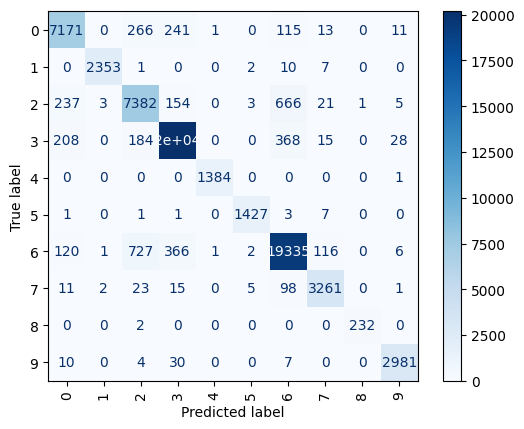

In [30]:
# ✅ 2. Confusion Matrix
# Shows how predictions are distributed across actual and predicted clusters.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')

✅ Step 1: What is GRU and Why Use It?
GRU (Gated Recurrent Unit) is a type of Recurrent Neural Network (RNN) designed to model sequential data like time series or text.

In our case:

Each taxi's movement through GMM clusters over time is a sequence.

GRU learns from past cluster transitions to predict the next cluster.

This is ideal for fleet movement prediction.

✅ Step 2: What Will Be the Input and Output?
Input (X): Sequences of GMM cluster IDs for each taxi (converted to one-hot vectors or embeddings).

Output (y): The next GMM cluster in the sequence.

For example, with seq_length = 2:

Input: [3, 6] → Output: 2

Input: [6, 2] → Output: 3

Each row of training data is a snippet of a taxi's journey.

✅ Step 3: What Libraries Do We Need?
You'll need:

In [31]:
!pip install tensorflow

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/375.9 MB 24.8 MB/s eta 0:00:16
   ---------------------------------------- 2.5/375.9 MB 32.2 MB/s eta 0:00:12
   ---------------------------------------- 4.6/375.9 MB 36.5 MB/s eta 0:00:11
    --------------------------------------- 7.2/375.9 MB 41.8 MB/s eta 0:00:09
    --------------------------------------- 9.2/375.9 MB 42.0 MB/s eta 0:00:09
   - -------------------------------------- 11.4/375.9 MB 46.7 MB/s eta 0:00:08
   - -------------------------------------- 13.8/375.9 MB 50.4 MB/s eta 0:00:08
   - -------------------------------------- 16.0/375.9 MB 46.7 MB/s eta 0:00:08
   - -------------------------------------- 17.9/375.9 MB 46.7 MB/s eta 0:00:08
   -- ------------------------------------- 20.2/375.9 MB 43.5

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
!pip install keras


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Dense, Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


ImportError: Traceback (most recent call last):
  File "c:\LegacyApp\Python\Python311\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.